In [1]:
%store -r input_w2v
# from undersampling_w2v.ipynb

In [2]:
%store -r w2v_df_labels
# from undersampling_w2v.ipynb

In [3]:
%store -r y_val
# from preprocessing_validation.ipynb

In [4]:
%store -r val_w2v_vectors
# from preprocessing_validation.ipynb

In [5]:
w2v_df_labels

,Argument ID,Openness to change,Self-Enhancement,Conservation,Self-Transcendence,labels
0,A01002,0,0,1,0,"[0.0, 0.0, 1.0, 0.0]"
1,A01005,0,0,1,0,"[0.0, 0.0, 1.0, 0.0]"
2,A01006,0,1,1,0,"[0.0, 0.5, 0.5, 0.0]"
3,A01007,0,0,2,1,"[0.0, 0.0, 0.6666666666666666, 0.3333333333333..."
4,A01008,0,0,1,2,"[0.0, 0.0, 0.3333333333333333, 0.6666666666666..."
...,...,...,...,...,...,...
5383,E08005,0,1,2,1,"[0.0, 0.25, 0.5, 0.25]"
5384,E08008,0,1,1,1,"[0.0, 0.3333333333333333, 0.3333333333333333, ..."
5385,E08009,0,1,1,0,"[0.0, 0.5, 0.5, 0.0]"
5387,E08016,0,2,1,1,"[0.0, 0.5, 0.25, 0.25]"


In [25]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding
from keras.utils import pad_sequences
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# this max_len variable will help pad the train and validation set
max_len_val = max(len(arg) for arg in val_w2v_vectors)
max_len_train = max(len(arg) for arg in input_w2v)  
print(max_len_val, max_len_train)

163 147


In [8]:
# we choose the highest max_len so that we don't lose information
max_len = 163

In [9]:
# we pad the train and validation set and create the labels for training
X_train = pad_sequences(input_w2v, maxlen=max_len)
X_val = pad_sequences(val_w2v_vectors, max_len)
train_labels = [row.labels for id, row in w2v_df_labels.iterrows()]

In [10]:
# to implement our classification problem (that is multi-class and multi-label) we will use binary crossentropy with a sigmoid activation
# function in the last layer: now we transform our probabilities labels in "binary" labels.
y_train = []
for label in train_labels:
    new_label = []
    for value in label:
        if value > 0:
            new_label.append(1)
        else:
            new_label.append(0)
    y_train.append(new_label)


In [11]:
# we tranform our y_train in an array
y_train = np.array(y_train)

In [12]:
# we make sure the train and validation set have the same embedding dimension and we set it as the variable "emb_len"
print(len(X_train[0][0]), len(X_val[0][0]))
emb_len = len(X_val[0][0])

150 150


In [13]:
# using early stopping to make sure we don't overfit the small dataset
from keras.callbacks import EarlyStopping

# define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

In [14]:
X_val.shape

(1576, 163, 150)

In [15]:
y_val.shape

(1576, 4)

In [16]:
y_train.shape

(2770, 4)

In [17]:
X_train.shape

(2770, 163, 150)

In [18]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [169]:
# we first tried different architectures and found out the one with two layers of LSTM and no layer of dropout was the best one

# we create a threshold to convert probabilities given by the sigmoid activation function in binary prediction for our classification report
threshold = 0.5

model = Sequential()
model.add(LSTM(100, dropout= 0.3, return_sequences=True, recurrent_dropout= 0.3, input_shape = (max_len, emb_len), activation="relu"))
model.add(Dropout(0.3))
model.add(LSTM(50, dropout=0.3, recurrent_dropout=0.3, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(4, activation='sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer="adam", metrics="accuracy")

history = model.fit(X_train, y_train,
        epochs=10,
        validation_data=(X_val, y_val),
        batch_size=64,
        verbose=1,
        callbacks=[early_stopping])

y_pred_probs = model.predict(X_val)

# convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > threshold).astype(int)

# print classification report
print(classification_report(y_val, y_pred_binary))

# calculate and return accuracy or other primary metric
accuracy = accuracy_score(y_val, y_pred_binary)
# this accuracy is less indicative since it computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
accuracy

Epoch 1/10
44/44 [==============================] - 29s 573ms/step - loss: 0.6578 - accuracy: 0.0913 - val_loss: 0.6648 - val_accuracy: 0.2989
Epoch 2/10
44/44 [==============================] - 26s 602ms/step - loss: 0.6290 - accuracy: 0.1787 - val_loss: 0.6676 - val_accuracy: 0.2576
Epoch 3/10
44/44 [==============================] - 26s 601ms/step - loss: 0.6102 - accuracy: 0.3101 - val_loss: 0.6791 - val_accuracy: 0.2195
Epoch 4/10
44/44 [==============================] - 27s 612ms/step - loss: 0.5957 - accuracy: 0.3996 - val_loss: 0.6797 - val_accuracy: 0.1466
Epoch 5/10
44/44 [==============================] - 27s 611ms/step - loss: 2307436032.0000 - accuracy: 0.4329 - val_loss: 17001851387904.0000 - val_accuracy: 0.3896
Epoch 6/10
44/44 [==============================] - 26s 598ms/step - loss: 116543459426304.0000 - accuracy: 0.3329 - val_loss: 804246912.0000 - val_accuracy: 0.1485
Epoch 7/10
44/44 [==============================] - 26s 599ms/step - loss: 2323.1443 - accuracy: 0

0.12436548223350254

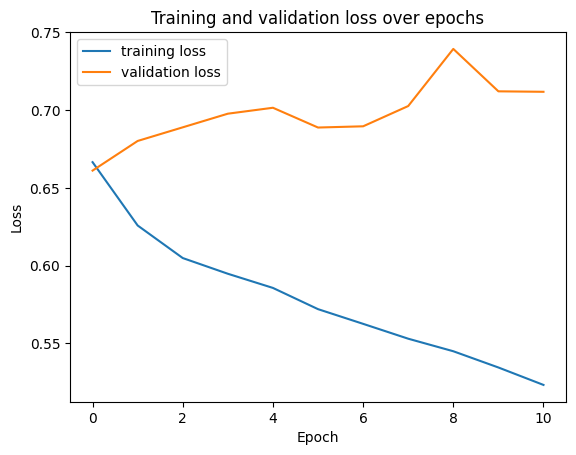

In [ ]:
#plot training loss and validation loss
plt.plot(history.history["loss"], label = "training loss")
plt.plot(history.history["val_loss"], label = "validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and validation loss over epochs")
plt.legend()
plt.show()

In [19]:
import tensorflow as tf

In [20]:
# we first define a function that will be a scheduler and will permit to our learning rate to decrease over epochs
def scheduler(epoch, lr):
    if epoch < 6:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [21]:
from keras.callbacks import LearningRateScheduler

In [22]:
gridsearch = {
    "batch" : [32, 64, 128],
    "dropout" : [0.3],
    "optimizer" : ["adam", "adagrad"],
}

In [388]:
def train_evaluate_lstm(params, X_train, X_val, y_train, y_val): 
        """Function that trains an lstm model given a list of params, a training set and 
        a validation set with their respective labels. It returns the mean of the validation
        accuracy."""

        initial_lr = 0.001  # the default starting learning rate for Adam and Adagrad
 
        patience = 10  

        # the learning rate scheduler takes as input a function that returns the desired learning rate for a given epoch
        lr_scheduler = LearningRateScheduler(lambda epoch: scheduler(epoch, initial_lr)) 

        early_stopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)

        threshold = 0.5

        model = Sequential()
        model.add(LSTM(100, dropout= 0.3, return_sequences=True, recurrent_dropout= 0.3, input_shape = (max_len, emb_len), activation="relu"))
        model.add(Dropout(0.3))
        model.add(LSTM(50, dropout=0.3, recurrent_dropout=0.3, activation="relu"))
        model.add(Dropout(0.3))
        model.add(Dense(4, activation='sigmoid'))

        # compile the model
        model.compile(loss='binary_crossentropy', optimizer=params["optimizer"], metrics=['accuracy'])

        history = model.fit(X_train, y_train,
                epochs=50,
                validation_data=(X_val, y_val),
                batch_size=params["batch"],
                verbose=1,
                callbacks=[early_stopping, lr_scheduler])

        y_pred_probs = model.predict(X_val)

        # convert probabilities to binary predictions
        y_pred_binary = (y_pred_probs > threshold).astype(int)

        # print classification report
        print("Parameters:", params)
        print(classification_report(y_val, y_pred_binary))

        # calculate and return accuracy or other primary metric
        accuracy = accuracy_score(y_val, y_pred_binary)
        return accuracy

In [389]:
from itertools import product
from tqdm import tqdm

best_score = 0
best_params = None

# Create all combinations of parameters
param_combinations = [dict(zip(gridsearch.keys(), v)) for v in product(*gridsearch.values())]
for params in tqdm(param_combinations):
    score = train_evaluate_lstm(params, X_train, X_val, y_train, y_val)
    if score > best_score:
        best_score = score
        best_params = params

print("Best Score:", best_score)
print("Best Parameters:", best_params)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/50
87/87 [==============================] - 40s 419ms/step - loss: 0.6389 - accuracy: 0.2509 - val_loss: 0.6784 - val_accuracy: 0.2684 - lr: 0.0010
Epoch 2/50
87/87 [==============================] - 31s 360ms/step - loss: 0.5999 - accuracy: 0.4108 - val_loss: 0.6856 - val_accuracy: 0.1624 - lr: 0.0010
Epoch 3/50
87/87 [==============================] - 31s 357ms/step - loss: 0.5845 - accuracy: 0.4671 - val_loss: 0.7064 - val_accuracy: 0.1885 - lr: 0.0010
Epoch 4/50
87/87 [==============================] - 31s 358ms/step - loss: 0.5691 - accuracy: 0.4610 - val_loss: 0.7106 - val_accuracy: 0.1732 - lr: 0.0010
Epoch 5/50
87/87 [==============================] - 31s 357ms/step - loss: 0.5598 - accuracy: 0.4747 - val_loss: 0.7120 - val_accuracy: 0.1732 - lr: 0.0010
Epoch 6/50
87/87 [==============================] - 31s 355ms/step - loss: 0.5393 - accuracy: 0.4726 - val_loss: 0.7260 - val_accuracy: 0.1751 - lr: 0.0010
Epoch 7/50
87/87 [==============================] - 31s 355ms/st

 17%|█▋        | 1/6 [05:58<29:54, 358.95s/it]

Parameters: {'batch': 32, 'dropout': 0.3, 'optimizer': 'adam'}
              precision    recall  f1-score   support

           0       0.37      0.43      0.40       614
           1       0.42      0.93      0.58       660
           2       0.75      1.00      0.86      1181
           3       0.76      1.00      0.87      1204

   micro avg       0.61      0.89      0.73      3659
   macro avg       0.58      0.84      0.67      3659
weighted avg       0.63      0.89      0.73      3659
 samples avg       0.62      0.90      0.71      3659

Epoch 1/50
87/87 [==============================] - 36s 375ms/step - loss: 0.6998 - accuracy: 0.2755 - val_loss: 0.6931 - val_accuracy: 0.2278 - lr: 0.0010
Epoch 2/50
87/87 [==============================] - 30s 346ms/step - loss: 0.6974 - accuracy: 0.2664 - val_loss: 0.6910 - val_accuracy: 0.2284 - lr: 0.0010
Epoch 3/50
87/87 [==============================] - 30s 348ms/step - loss: 0.6945 - accuracy: 0.2628 - val_loss: 0.6892 - val_accuracy: 

 33%|███▎      | 2/6 [31:37<1:10:11, 1052.76s/it]

Parameters: {'batch': 32, 'dropout': 0.3, 'optimizer': 'adagrad'}
              precision    recall  f1-score   support

           0       0.39      1.00      0.56       614
           1       0.42      1.00      0.59       660
           2       0.75      1.00      0.86      1181
           3       0.76      1.00      0.87      1204

   micro avg       0.58      1.00      0.73      3659
   macro avg       0.58      1.00      0.72      3659
weighted avg       0.63      1.00      0.76      3659
 samples avg       0.58      1.00      0.71      3659

Epoch 1/50
44/44 [==============================] - 42s 873ms/step - loss: 0.6760 - accuracy: 0.1560 - val_loss: 0.6723 - val_accuracy: 0.2627 - lr: 0.0010
Epoch 2/50
44/44 [==============================] - 39s 894ms/step - loss: 0.6488 - accuracy: 0.1097 - val_loss: 0.6685 - val_accuracy: 0.2367 - lr: 0.0010
Epoch 3/50
44/44 [==============================] - 39s 892ms/step - loss: 0.6454 - accuracy: 0.1069 - val_loss: 0.6663 - val_accurac

 50%|█████     | 3/6 [44:11<45:48, 916.21s/it]   

Epoch 1/50
44/44 [==============================] - 44s 925ms/step - loss: 0.6858 - accuracy: 0.3155 - val_loss: 0.6931 - val_accuracy: 0.3020 - lr: 0.0010
Epoch 2/50
44/44 [==============================] - 43s 984ms/step - loss: 0.6847 - accuracy: 0.3116 - val_loss: 0.6923 - val_accuracy: 0.2963 - lr: 0.0010
Epoch 3/50
44/44 [==============================] - 43s 989ms/step - loss: 0.6823 - accuracy: 0.3191 - val_loss: 0.6916 - val_accuracy: 0.2906 - lr: 0.0010
Epoch 4/50
44/44 [==============================] - 43s 990ms/step - loss: 0.6828 - accuracy: 0.3173 - val_loss: 0.6909 - val_accuracy: 0.2881 - lr: 0.0010
Epoch 5/50
44/44 [==============================] - 43s 990ms/step - loss: 0.6815 - accuracy: 0.3051 - val_loss: 0.6902 - val_accuracy: 0.2849 - lr: 0.0010
Epoch 6/50
44/44 [==============================] - 44s 996ms/step - loss: 0.6805 - accuracy: 0.3022 - val_loss: 0.6896 - val_accuracy: 0.2824 - lr: 0.0010
Epoch 7/50
44/44 [==============================] - 44s 992ms/st

 67%|██████▋   | 4/6 [1:20:35<47:13, 1416.94s/it]

Parameters: {'batch': 64, 'dropout': 0.3, 'optimizer': 'adagrad'}
              precision    recall  f1-score   support

           0       0.39      1.00      0.56       614
           1       0.42      1.00      0.59       660
           2       0.75      1.00      0.86      1181
           3       0.76      1.00      0.87      1204

   micro avg       0.58      1.00      0.73      3659
   macro avg       0.58      1.00      0.72      3659
weighted avg       0.63      1.00      0.76      3659
 samples avg       0.58      1.00      0.71      3659

Epoch 1/50
22/22 [==============================] - 56s 2s/step - loss: 0.6542 - accuracy: 0.1422 - val_loss: 0.6682 - val_accuracy: 0.1929 - lr: 0.0010
Epoch 2/50
22/22 [==============================] - 53s 2s/step - loss: 0.6187 - accuracy: 0.2892 - val_loss: 0.6783 - val_accuracy: 0.2405 - lr: 0.0010
Epoch 3/50
22/22 [==============================] - 52s 2s/step - loss: 0.6500 - accuracy: 0.3321 - val_loss: 0.6802 - val_accuracy: 0.1796

 83%|████████▎ | 5/6 [1:30:24<18:38, 1118.20s/it]

Parameters: {'batch': 128, 'dropout': 0.3, 'optimizer': 'adam'}
              precision    recall  f1-score   support

           0       0.38      0.81      0.52       614
           1       0.42      0.92      0.57       660
           2       0.75      1.00      0.86      1181
           3       0.76      1.00      0.87      1204

   micro avg       0.59      0.95      0.73      3659
   macro avg       0.58      0.93      0.70      3659
weighted avg       0.63      0.95      0.75      3659
 samples avg       0.59      0.96      0.71      3659

Epoch 1/50
22/22 [==============================] - 55s 2s/step - loss: 0.6967 - accuracy: 0.3271 - val_loss: 0.6993 - val_accuracy: 0.3458 - lr: 0.0010
Epoch 2/50
22/22 [==============================] - 51s 2s/step - loss: 0.6961 - accuracy: 0.3253 - val_loss: 0.6988 - val_accuracy: 0.3420 - lr: 0.0010
Epoch 3/50
22/22 [==============================] - 51s 2s/step - loss: 0.6954 - accuracy: 0.3256 - val_loss: 0.6983 - val_accuracy: 0.3401 -

100%|██████████| 6/6 [2:13:31<00:00, 1335.31s/it]

 {'batch': 128, 'dropout': 0.3, 'optimizer': 'adagrad'}
              precision    recall  f1-score   support

           0       0.39      0.99      0.56       614
           1       0.42      0.99      0.59       660
           2       0.75      1.00      0.86      1181
           3       0.76      0.94      0.84      1204

   micro avg       0.58      0.98      0.73      3659
   macro avg       0.58      0.98      0.71      3659
weighted avg       0.63      0.98      0.75      3659
 samples avg       0.58      0.98      0.70      3659

Best Score: 0.11230964467005077
Best Parameters: {'batch': 32, 'dropout': 0.3, 'optimizer': 'adam'}


In [407]:
# judging by the classification report we chose the parameters that seemed to give us the best model based on the mean f1-score

best_params = {'batch': 64, 'dropout': 0.3, 'optimizer': 'adam'}

initial_lr = 0.001  # the default starting learning rate for Adam

patience = 10  

# the learning rate scheduler takes as input a function that returns the desired learning rate for a given epoch
lr_scheduler = LearningRateScheduler(lambda epoch: scheduler(epoch, initial_lr)) 
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)

threshold = 0.5

model = Sequential()
model.add(LSTM(100, dropout=best_params["dropout"], return_sequences=True, recurrent_dropout= best_params["dropout"], input_shape = (max_len, emb_len), activation="relu"))
model.add(Dropout(best_params["dropout"]))
model.add(LSTM(50, dropout=best_params["dropout"], recurrent_dropout=best_params["dropout"], activation="relu"))
model.add(Dropout(best_params["dropout"]))
model.add(Dense(4, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=best_params["optimizer"], metrics=['accuracy'])

history = model.fit(X_train, y_train,
        epochs=50,
        validation_data=(X_val, y_val),
        batch_size=best_params["batch"],
        verbose=1,
        callbacks=[early_stopping, lr_scheduler])

y_pred_probs = model.predict(X_val)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > threshold).astype(int)

# Print classification report
print(classification_report(y_val, y_pred_binary))


Epoch 1/50
44/44 [==============================] - 65s 1s/step - loss: 0.6463 - accuracy: 0.1823 - val_loss: 0.6688 - val_accuracy: 0.2011 - lr: 0.0010
Epoch 2/50
44/44 [==============================] - 62s 1s/step - loss: 0.6187 - accuracy: 0.3711 - val_loss: 0.6767 - val_accuracy: 0.2405 - lr: 0.0010
Epoch 3/50
44/44 [==============================] - 69s 2s/step - loss: 0.6013 - accuracy: 0.3845 - val_loss: 0.6703 - val_accuracy: 0.1624 - lr: 0.0010
Epoch 4/50
44/44 [==============================] - 66s 1s/step - loss: 0.5915 - accuracy: 0.3978 - val_loss: 0.6819 - val_accuracy: 0.1802 - lr: 0.0010
Epoch 5/50
44/44 [==============================] - 70s 2s/step - loss: 0.5818 - accuracy: 0.4390 - val_loss: 0.6855 - val_accuracy: 0.1675 - lr: 0.0010
Epoch 6/50
44/44 [==============================] - 65s 1s/step - loss: 0.5726 - accuracy: 0.4354 - val_loss: 0.7077 - val_accuracy: 0.1681 - lr: 0.0010
Epoch 7/50
44/44 [==============================] - 64s 1s/step - loss: 0.5598 - a

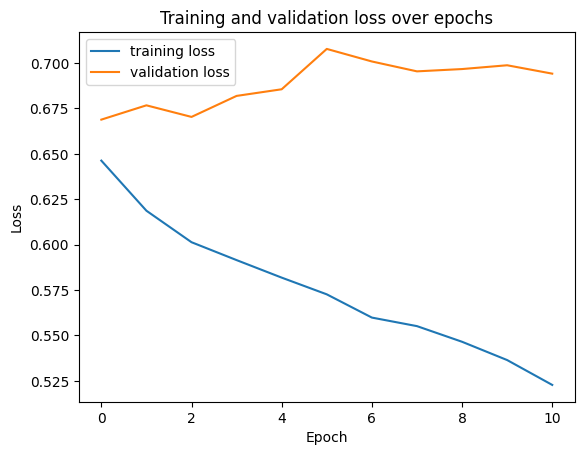

In [409]:
#plot training loss and validation loss
plt.plot(history.history["loss"], label = "training loss")
plt.plot(history.history["val_loss"], label = "validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and validation loss over epochs")
plt.legend()
plt.show()

Epoch 1/50
44/44 [==============================] - 81s 2s/step - loss: 0.6919 - accuracy: 0.2029 - val_loss: 0.6810 - val_accuracy: 0.1326 - lr: 0.0010
Epoch 2/50
44/44 [==============================] - 41s 940ms/step - loss: 0.6619 - accuracy: 0.1823 - val_loss: 0.6785 - val_accuracy: 0.1282 - lr: 0.0010
Epoch 3/50
44/44 [==============================] - 41s 942ms/step - loss: 0.6621 - accuracy: 0.1238 - val_loss: 0.6763 - val_accuracy: 0.2430 - lr: 0.0010
Epoch 4/50
44/44 [==============================] - 41s 945ms/step - loss: 0.6600 - accuracy: 0.1307 - val_loss: 0.6756 - val_accuracy: 0.2627 - lr: 0.0010
Epoch 5/50
44/44 [==============================] - 42s 966ms/step - loss: 0.6543 - accuracy: 0.1170 - val_loss: 0.6744 - val_accuracy: 0.2716 - lr: 0.0010
Epoch 6/50
44/44 [==============================] - 46s 1s/step - loss: 0.6528 - accuracy: 0.1051 - val_loss: 0.6730 - val_accuracy: 0.2627 - lr: 0.0010
Epoch 7/50
44/44 [==============================] - 46s 1s/step - loss

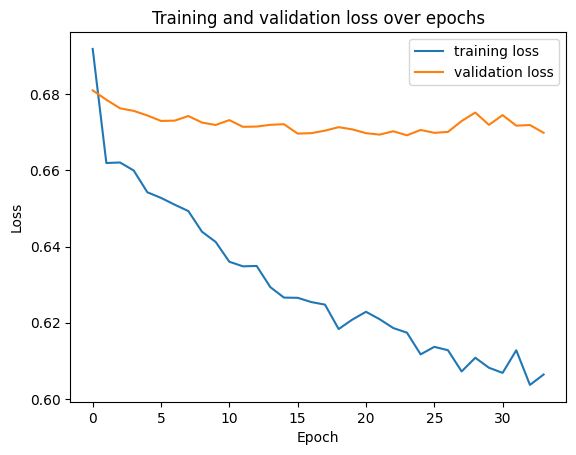

In [414]:
# hoping to reduce overfitting we decided to increase the dropout rate at 0.7
# judging by the classification report we chose the parameters that seemed to give us the best model based on the mean f1-score

best_params = {'batch': 64, 'dropout': 0.7, 'optimizer': 'adam'}

initial_lr = 0.001  # the default starting learning rate for Adam

patience = 10  

# the learning rate scheduler takes as input a function that returns the desired learning rate for a given epoch
lr_scheduler = LearningRateScheduler(lambda epoch: scheduler(epoch, initial_lr)) 
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)

threshold = 0.6

model = Sequential()
model.add(LSTM(100, dropout=best_params["dropout"], return_sequences=True, recurrent_dropout= best_params["dropout"], input_shape = (max_len, emb_len), activation="relu"))
model.add(Dropout(best_params["dropout"]))
model.add(LSTM(50, dropout=best_params["dropout"], recurrent_dropout=best_params["dropout"], activation="relu"))
model.add(Dropout(best_params["dropout"]))
model.add(Dense(4, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=best_params["optimizer"], metrics=['accuracy'])

history = model.fit(X_train, y_train,
        epochs=50,
        validation_data=(X_val, y_val),
        batch_size=best_params["batch"],
        verbose=1,
        callbacks=[early_stopping, lr_scheduler])

y_pred_probs = model.predict(X_val)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > threshold).astype(int)

# Print classification report
print(classification_report(y_val, y_pred_binary))

#plot training loss and validation loss
plt.plot(history.history["loss"], label = "training loss")
plt.plot(history.history["val_loss"], label = "validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and validation loss over epochs")
plt.legend()
plt.show()


In [471]:
y_pred_probs

array([[0.5215948 , 0.6090773 , 0.60697854, 0.63256   ],
       [0.55124   , 0.56883025, 0.5875583 , 0.61892146],
       [0.5401921 , 0.57526577, 0.5845827 , 0.6174972 ],
       ...,
       [0.4901238 , 0.6743161 , 0.65440613, 0.6650407 ],
       [0.5110638 , 0.65876114, 0.6406957 , 0.6532417 ],
       [0.5265207 , 0.59945196, 0.59648466, 0.62787545]], dtype=float32)

We will now try to implement embedding layer to make the word2vec vectors trainable and see if it improves our performance

In [50]:
%store -r w2v_model
# from word2vec.ipynb

In [51]:
%store -r df
# from undersampling.ipynb, it's the dataframe with the IDs of the arguments mantained after undersampling

In [52]:
df_train = pd.read_csv("arguments-training.tsv", sep = "\t")
df_train.head()

,Argument ID,Conclusion,Stance,Premise
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...


In [53]:
df

,Argument ID,Openness to change,Self-Enhancement,Conservation,Self-Transcendence,labels
0,A01002,0,0,1,0,"[0.0, 0.0, 1.0, 0.0]"
1,A01005,0,0,1,0,"[0.0, 0.0, 1.0, 0.0]"
2,A01006,0,1,1,0,"[0.0, 0.5, 0.5, 0.0]"
3,A01007,0,0,2,1,"[0.0, 0.0, 0.6666666666666666, 0.3333333333333..."
4,A01008,0,0,1,2,"[0.0, 0.0, 0.3333333333333333, 0.6666666666666..."
...,...,...,...,...,...,...
5383,E08005,0,1,2,1,"[0.0, 0.25, 0.5, 0.25]"
5384,E08008,0,1,1,1,"[0.0, 0.3333333333333333, 0.3333333333333333, ..."
5385,E08009,0,1,1,0,"[0.0, 0.5, 0.5, 0.0]"
5387,E08016,0,2,1,1,"[0.0, 0.5, 0.25, 0.25]"


In [54]:
df.rename(columns={"Argument ID": "Argument_ID"}, inplace=True)
df_train.rename(columns={"Argument ID": "Argument_ID"}, inplace=True)

In [55]:
# we merge the training dataframe and the df after the undersampling 
merged_df_train = pd.merge(df, df_train, on='Argument_ID', how='inner')
merged_df_train

,Argument_ID,Openness to change,Self-Enhancement,Conservation,Self-Transcendence,labels,Conclusion,Stance,Premise
0,A01002,0,0,1,0,"[0.0, 0.0, 1.0, 0.0]",We should ban human cloning,in favor of,we should ban human cloning as it will only ca...
1,A01005,0,0,1,0,"[0.0, 0.0, 1.0, 0.0]",We should ban fast food,in favor of,fast food should be banned because it is reall...
2,A01006,0,1,1,0,"[0.0, 0.5, 0.5, 0.0]",We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...
3,A01007,0,0,2,1,"[0.0, 0.0, 0.6666666666666666, 0.3333333333333...",We should abolish capital punishment,against,capital punishment is sometimes the only optio...
4,A01008,0,0,1,2,"[0.0, 0.0, 0.3333333333333333, 0.6666666666666...",We should ban factory farming,against,factory farming allows for the production of c...
...,...,...,...,...,...,...,...,...,...
2765,E08005,0,1,2,1,"[0.0, 0.25, 0.5, 0.25]",The EU should integrate the armed forces of it...,in favor of,Absolutely right. Europe needs an army for con...
2766,E08008,0,1,1,1,"[0.0, 0.3333333333333333, 0.3333333333333333, ...",The EU should integrate the armed forces of it...,in favor of,"In principle, I would be in favor of a Europea..."
2767,E08009,0,1,1,0,"[0.0, 0.5, 0.5, 0.0]",The EU should integrate the armed forces of it...,in favor of,I agree with your idea. But it is a long and a...
2768,E08016,0,2,1,1,"[0.0, 0.5, 0.25, 0.25]",The EU should integrate the armed forces of it...,in favor of,"On the one hand, we have Russia killing countl..."


In [56]:
import spacy

In [57]:
# we now preprocess the text in the premise
# load the English language model
nlp = spacy.load("en_core_web_sm")

In [58]:
def preprocess_text(text):
    doc = nlp(text)
    # set lowercase
    processed_text = [token.text.lower()for token in doc]
    return processed_text

In [59]:
merged_df_train["premise_tokenized"] = merged_df_train["Premise"].apply(preprocess_text)

In [60]:
train_corpus = merged_df_train["premise_tokenized"].tolist()

In [61]:
from keras.preprocessing.text import Tokenizer

In [62]:
import nltk
from nltk.corpus import stopwords


In [63]:
stop_words = set(stopwords.words('english'))

In [64]:
# we selected from the most frequent words those that seemed to too frequent (people) or less informative (would, n't, many and 's)
most_freq_words = ["people", "would", "'n't", "many", "'s"]
custom_stop_words = list(stop_words)
custom_stop_words.append("people")
custom_stop_words = set(custom_stop_words)

In [65]:

# we now need to modify the validation  inputs so that they are a list of integers that can be fed to an Embedding layer. 
# We first create the validation corpus
val_df = pd.read_csv("arguments-validation.tsv", sep = "\t")
val_df = val_df.iloc[:1576]
val_df["premise_tokenized"] = val_df["Premise"].apply(preprocess_text)
val_corpus = val_df["premise_tokenized"].tolist()

In [66]:
# Modifying the train and validation corpus, excluding stop_words
train_corpus = [[token for token in doc if token not in custom_stop_words] for doc in train_corpus]
# remove numbers, but not words that contain numbers.
train_corpus = [[token for token in doc if not token.isnumeric()] for doc in train_corpus]
# remove words that are only one character.
train_corpus = [[token for token in doc if len(token) > 1] for doc in train_corpus]

val_corpus = [[token for token in doc if token not in custom_stop_words] for doc in val_corpus]
val_corpus = [[token for token in doc if not token.isnumeric()] for doc in val_corpus]
val_corpus = [[token for token in doc if len(token) > 1] for doc in val_corpus]

In [67]:
# we now create a dictionary that has for keys the words in out dictionary and for values thei integer indices
t = Tokenizer()
t.fit_on_texts(train_corpus)
train_w2id = t.word_index 

In [240]:
# we now create and embedding matrix with same number of rows as the size of the vocabulary and same number of columns as the w2v features
vocab_size = len(train_w2id) + 1

embedding_matrix = np.zeros((vocab_size, emb_len))

for word, i in train_w2id.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

embedding_matrix.shape

(5364, 150)

In [241]:
# Now we tranform the corpus in a list of integers representing the words for each document
X_train_seq = t.texts_to_sequences(train_corpus)
X_val_seq = t.texts_to_sequences(val_corpus)

In [242]:
# padding the sequences
X_train_seq = pad_sequences(X_train_seq, max_len)
X_val_seq = pad_sequences(X_val_seq, max_len)

In [243]:
emb_layer = Embedding(input_dim=vocab_size, output_dim=emb_len, weights = [embedding_matrix], input_length = max_len, trainable = True)

In [244]:
lstm_emb = Sequential()


lstm_emb.add(emb_layer)
lstm_emb.add(LSTM(100, activation="relu", dropout=0.2, input_shape = (max_len, emb_len), return_sequences=True))
lstm_emb.add(Dropout(0.3))
lstm_emb.add(LSTM(50, activation="relu", dropout=0.2))
lstm_emb.add(Dropout(0.3))
lstm_emb.add(Dense(4, activation="sigmoid"))

lstm_emb.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [245]:
history = lstm_emb.fit(X_train_seq, y_train,
        epochs=5,
        validation_data=(X_val_seq, y_val),
        batch_size=64,
        verbose=1)



Epoch 1/5


44/44 [==============================] - 20s 307ms/step - loss: 0.6237 - accuracy: 0.2440 - val_loss: 0.6467 - val_accuracy: 0.2862
Epoch 2/5
44/44 [==============================] - 13s 294ms/step - loss: 0.5791 - accuracy: 0.3931 - val_loss: 0.6344 - val_accuracy: 0.3001
Epoch 3/5
44/44 [==============================] - 11s 254ms/step - loss: 0.5560 - accuracy: 0.4144 - val_loss: 0.6359 - val_accuracy: 0.3325
Epoch 4/5
44/44 [==============================] - 11s 253ms/step - loss: 0.5386 - accuracy: 0.4181 - val_loss: 0.6411 - val_accuracy: 0.3852
Epoch 5/5
44/44 [==============================] - 13s 291ms/step - loss: 0.5151 - accuracy: 0.4314 - val_loss: 0.6452 - val_accuracy: 0.3788


In [167]:
threshold = 0.5
y_pred_probs = lstm_emb.predict(X_val_seq)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > threshold).astype(int)

# Print classification report
print(classification_report(y_val, y_pred_binary))

50/50 [==============================] - 2s 26ms/step
              precision    recall  f1-score   support

           0       0.50      0.69      0.58       614
           1       0.51      0.83      0.63       660
           2       0.78      0.85      0.81      1181
           3       0.77      0.94      0.85      1204

   micro avg       0.66      0.85      0.75      3659
   macro avg       0.64      0.83      0.72      3659
weighted avg       0.68      0.85      0.75      3659
 samples avg       0.68      0.86      0.72      3659



In [96]:
y_val

array([[0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 1],
       ...,
       [1, 0, 1, 1],
       [0, 0, 1, 1],
       [1, 1, 1, 1]])

In [168]:
y_pred_probs

array([[0.36733866, 0.57474875, 0.61256826, 0.6799597 ],
       [0.24098738, 0.8706058 , 0.80069584, 0.6935707 ],
       [0.3276463 , 0.6352622 , 0.77044106, 0.78641385],
       ...,
       [0.58401424, 0.5954576 , 0.7766377 , 0.7667901 ],
       [0.56489366, 0.5144022 , 0.934897  , 0.7893493 ],
       [0.68643403, 0.65925103, 0.68188304, 0.7134536 ]], dtype=float32)

Since the performance doesn't seem to improve with trainable embeddings but, at least, the model doesn't generalize every class to [1, 1, 1, 1], we will test both our models.

But first, we need to pre-process the test set

In [26]:
arguments_test=pd.read_csv("arguments-test.tsv", sep='\t')

In [27]:
labels_test=pd.read_csv("labels-test.tsv", sep='\t')

In [28]:
# check for duplicate rows
duplicate_rows=arguments_test.duplicated().sum()
print(duplicate_rows)

0


In [29]:
# concatenate the two sets
test_set = pd.concat([arguments_test, labels_test], axis=1)

We now need to generalize the labels into 4

In [30]:
# we generalize labels according to the following dictionary
general_dictionary={
    "Self-direction: thought":"Openness to change",
    "Self-direction: action":"Openness to change",
    "Stimulation":"Openness to change",
    "Hedonism":"Openness to change",
    "Achievement":"Self-Enhancement",
    "Power: dominance":"Self-Enhancement",
    "Power: resources":"Self-Enhancement",
    "Face":"Self-Enhancement",
    "Security: personal":"Conservation",
    "Security: societal":"Conservation",
    "Tradition":"Conservation",
    "Conformity: rules":"Conservation",
    "Conformity: interpersonal":"Conservation",
    "Humility":"Conservation",
    "Benevolence: caring":"Self-Transcendence",
    "Benevolence: dependability":"Self-Transcendence",
    "Universalism: concern":"Self-Transcendence",
    "Universalism: nature":"Self-Transcendence",
    "Universalism: tolerance":"Self-Transcendence",
    "Universalism: objectivity":"Self-Transcendence"
    
}

In [31]:
test_set["Openness to change"]=test_set["Self-direction: thought"]+test_set["Self-direction: action"]+test_set["Stimulation"]+test_set["Hedonism"]

In [32]:
test_set["Self-Enhancement"]=test_set["Achievement"]+test_set["Power: dominance"]+test_set["Power: resources"]+test_set["Face"]

In [33]:
test_set["Conservation"]=test_set["Security: personal"]+test_set["Security: societal"]+test_set["Tradition"]+test_set["Conformity: rules"]+test_set["Conformity: interpersonal"]+test_set["Humility"]

In [34]:
test_set["Self-Transcendence"]=test_set["Benevolence: caring"]+test_set["Benevolence: dependability"]+test_set["Universalism: concern"]+test_set["Universalism: nature"]+test_set["Universalism: tolerance"]+test_set["Universalism: objectivity"]

In [35]:
# we now drop the original features
for key in general_dictionary:
    if key!=general_dictionary[key]:
        test_set=test_set.drop(key, axis=1)
    else:
        pass

In [36]:
# extract the generalized label columns and store them in a separate DataFrame
label_columns=test_set[[
"Openness to change",
"Self-Enhancement",
"Conservation",
"Self-Transcendence"]]

# convert the label columns to a multi-class format (one-hot encoding)
test_set['general_label'] = label_columns.apply(lambda row: row.to_list(), axis=1)
test_set

,Argument ID,Conclusion,Stance,Premise,Argument ID,Openness to change,Self-Enhancement,Conservation,Self-Transcendence,general_label
0,A26004,We should end affirmative action,against,affirmative action helps with employment equity.,A26004,0,1,1,2,"[0, 1, 1, 2]"
1,A26010,We should end affirmative action,in favor of,affirmative action can be considered discrimin...,A26010,0,1,0,3,"[0, 1, 0, 3]"
2,A26016,We should ban naturopathy,in favor of,naturopathy is very dangerous for the most vul...,A26016,0,1,1,2,"[0, 1, 1, 2]"
3,A26024,We should prohibit women in combat,in favor of,women shouldn't be in combat because they aren...,A26024,0,1,0,0,"[0, 1, 0, 0]"
4,A26026,We should ban naturopathy,in favor of,once eradicated illnesses are returning due to...,A26026,0,1,2,2,"[0, 1, 2, 2]"
...,...,...,...,...,...,...,...,...,...,...
1571,E07272,We should end mass migration together.,in favor of,Mass migration is a phenomenon that causes dam...,E07272,0,0,1,0,"[0, 0, 1, 0]"
1572,E07273,We should end mass migration together.,in favor of,Mass migration hurts the migrants themselves i...,E07273,0,0,1,2,"[0, 0, 1, 2]"
1573,E07275,We should consider Russian interests in the EU...,in favor of,It is neither in the interests of the EU nor R...,E07275,1,1,1,2,"[1, 1, 1, 2]"
1574,E07280,We should adopt an extension of the applicatio...,in favor of,Foreign Policy at the EU level should be based...,E07280,1,1,0,2,"[1, 1, 0, 2]"


In [37]:
# tranform the labels in binary encoding
binary_labels = []

for label in test_set["general_label"]:
    new_label = []

    for value in label:
        if value > 0:
            new_label.append(1)
        else:
            new_label.append(0)

    binary_labels.append(new_label)

In [38]:
y_test = np.array(binary_labels)

This is the testing for the lstm with trainable embeddings:

In [68]:
# we first tokenize the premises from the test set
test_set["premise_tokenized"] = test_set["Premise"].apply(preprocess_text)
test_corpus = test_set["premise_tokenized"].tolist()

In [69]:
# now we process the corpus eliminating stopwords and numbers
test_corpus = [[token for token in doc if token not in custom_stop_words] for doc in test_corpus]
test_corpus = [[token for token in doc if not token.isnumeric()] for doc in test_corpus]
test_corpus = [[token for token in doc if len(token) > 1] for doc in test_corpus]

In [261]:
# Now we tranform the corpus in a list of integers representing the words for each document
X_test_seq = t.texts_to_sequences(test_corpus)

In [262]:
# padding the sequences
X_test_seq = pad_sequences(X_test_seq, max_len)

In [263]:
# we now extract the probabilities for the test set from the previously trained model
threshold = 0.5
y_pred_probs = lstm_emb.predict(X_test_seq)

# convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > threshold).astype(int)

# print classification report
print(classification_report(y_test, y_pred_binary))

 3/50 [>.............................] - ETA: 1s 

50/50 [==============================] - 2s 33ms/step
              precision    recall  f1-score   support

           0       0.35      0.83      0.49       474
           1       0.48      0.79      0.60       628
           2       0.72      0.92      0.81      1082
           3       0.81      0.97      0.88      1254

   micro avg       0.61      0.90      0.73      3438
   macro avg       0.59      0.88      0.69      3438
weighted avg       0.66      0.90      0.75      3438
 samples avg       0.63      0.91      0.71      3438



In [264]:
# as we can see the performance isn't as good as the previous lstm model without trainable embeddings, but at least our model doesn't generalize every class to [1, 1, 1, 1]
y_pred_binary

array([[1, 1, 1, 1],
       [1, 1, 1, 1],
       [0, 1, 1, 1],
       ...,
       [0, 1, 1, 1],
       [1, 1, 1, 1],
       [0, 1, 1, 1]])

Now we test the lstm model with word2vec embeddings

In [70]:
%store -r w2v_model
# from word2vec.ipynb

In [71]:
# create the vectors from the w2v model for the test set
test_w2v_vectors = []
for arg in test_set["premise_tokenized"]:
    seq = []

    for word in arg:
        if word in w2v_model.wv:
            seq.append(w2v_model.wv[word])
        else:
            seq.append(np.zeros(150)) #if the word is not in the model i append an array of zeros equal to the embeddings dimension, that is 150
        
    test_w2v_vectors.append(seq)

In [72]:
test_w2v_vectors = [np.array(arg) for arg in test_w2v_vectors]

In [73]:
# this max_len variable will help pad the train and validation set and test set
max_len_val = max(len(arg) for arg in val_w2v_vectors)
max_len_train = max(len(arg) for arg in input_w2v)
max_len_test = max(len(arg) for arg in test_w2v_vectors)  
print(max_len_val, max_len_train, max_len_test)

163 147 163


In [74]:
# we choose the highest max_len so that we don't lose information
max_len = 163

In [75]:
# we pad the test set
X_test = pad_sequences(test_w2v_vectors, max_len)

In [76]:
# we make sure the train, test and validation set have the same embedding dimension
print(len(X_train[0][0]), len(X_val[0][0]), len(X_test[0][0]))

150 150 150


In [77]:
best_params = {'batch': 64, 'dropout': 0.7, 'optimizer': 'adam'}

initial_lr = 0.001  # the default starting learning rate for Adam

patience = 10  

# the learning rate scheduler takes as input a function that returns the desired learning rate for a given epoch
lr_scheduler = LearningRateScheduler(lambda epoch: scheduler(epoch, initial_lr)) 
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)

threshold = 0.5

lstm_final_model = Sequential()
lstm_final_model.add(LSTM(100, dropout=best_params["dropout"], return_sequences=True, recurrent_dropout= best_params["dropout"], input_shape = (max_len, emb_len), activation="relu"))
lstm_final_model.add(Dropout(best_params["dropout"]))
lstm_final_model.add(LSTM(50, dropout=best_params["dropout"], recurrent_dropout=best_params["dropout"], activation="relu"))
lstm_final_model.add(Dropout(best_params["dropout"]))
lstm_final_model.add(Dense(4, activation='sigmoid'))

# Compile the model
lstm_final_model.compile(loss='binary_crossentropy', optimizer=best_params["optimizer"], metrics=['accuracy'])

history = lstm_final_model.fit(X_train, y_train,
        epochs=50,
        validation_data=(X_val, y_val),
        batch_size=best_params["batch"],
        verbose=1,
        callbacks=[early_stopping, lr_scheduler])

lstm_final_model.save('lstm_model.h5')

y_pred_probs = lstm_final_model.predict(X_test)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > threshold).astype(int)

# Print classification report
print(classification_report(y_test, y_pred_binary))



Epoch 1/50


44/44 [==============================] - 26s 409ms/step - loss: 0.7162 - accuracy: 0.2433 - val_loss: 0.6818 - val_accuracy: 0.2779 - lr: 0.0010
Epoch 2/50
44/44 [==============================] - 22s 508ms/step - loss: 0.6709 - accuracy: 0.1603 - val_loss: 0.6780 - val_accuracy: 0.2094 - lr: 0.0010
Epoch 3/50
44/44 [==============================] - 25s 581ms/step - loss: 0.6642 - accuracy: 0.1401 - val_loss: 0.6764 - val_accuracy: 0.2329 - lr: 0.0010
Epoch 4/50
44/44 [==============================] - 26s 583ms/step - loss: 0.6601 - accuracy: 0.1303 - val_loss: 0.6750 - val_accuracy: 0.2690 - lr: 0.0010
Epoch 5/50
44/44 [==============================] - 26s 591ms/step - loss: 0.6598 - accuracy: 0.1184 - val_loss: 0.6747 - val_accuracy: 0.2386 - lr: 0.0010
Epoch 6/50
44/44 [==============================] - 27s 621ms/step - loss: 0.6564 - accuracy: 0.0978 - val_loss: 0.6724 - val_accuracy: 0.2227 - lr: 0.0010
Epoch 7/50
44/44 [==============================] - 31s 712m

c:\Users\cate9\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 [==============================] - 4s 62ms/step
              precision    recall  f1-score   support

           0       0.30      0.98      0.46       474
           1       0.40      0.99      0.57       628
           2       0.69      1.00      0.81      1082
           3       0.80      1.00      0.89      1254

   micro avg       0.55      1.00      0.71      3438
   macro avg       0.55      0.99      0.68      3438
weighted avg       0.62      1.00      0.75      3438
 samples avg       0.55      1.00      0.69      3438



In [78]:
import matplotlib.pyplot as plt

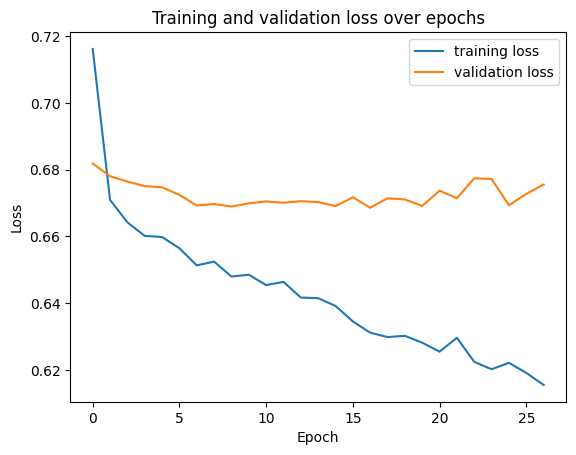

In [79]:
#plot training loss and validation loss
plt.plot(history.history["loss"], label = "training loss")
plt.plot(history.history["val_loss"], label = "validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and validation loss over epochs")
plt.legend()
plt.show()

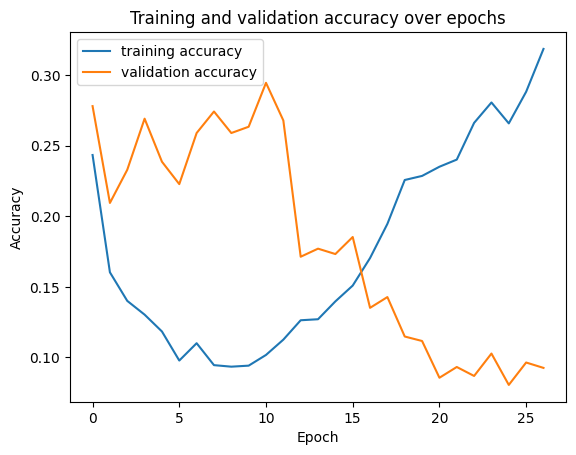

In [80]:
#plot training accuracy and validation accuracy
plt.plot(history.history["accuracy"], label = "training accuracy")
plt.plot(history.history["val_accuracy"], label = "validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracy over epochs")
plt.legend()
plt.show()